In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

In [2]:
X = pd.read_csv("../data/processed/X_reduced_young_gr.csv")
y = pd.read_csv("../data/processed/y_young_gr.csv").squeeze()

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=10
)
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (14060, 18)
X_test: (6026, 18)
y_train: (14060,)
y_test: (6026,)


In [4]:
# linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# test the model both train and test
train_score = lr_model.score(X_train, y_train)
test_score = lr_model.score(X_test, y_test)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")

Train Score: 0.988297900194864
Test Score: 0.9887263253056615


In [5]:
# calculate intercept and coefficients
intercept = lr_model.intercept_
coefficients = lr_model.coef_
print("Intercept:", intercept)
print("Coefficients:", coefficients)

Intercept: 3978.8235284382545
Coefficients: [-7.22903185e+00  1.95361819e+01 -1.26452776e+00  7.00112526e+03
  4.99698873e+03  1.10914836e+03  8.17798831e+00  1.67735268e+00
 -3.27532710e+00  6.31709531e+00  1.60689716e+01  8.12844929e+02
  4.00375598e+02  1.07529819e+02  2.05069661e+02  6.10983280e+02
  3.87836470e-02 -5.24201812e+00]


In [6]:
# feature importance based on coefficients
coef_df = pd.DataFrame(coefficients, index=X_test.columns, columns=["Coefficient"]).sort_values(by="Coefficient", ascending=True)


/tmp/ipykernel_178816/559273050.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y=coef_df.index, data=coef_df, palette="viridis")


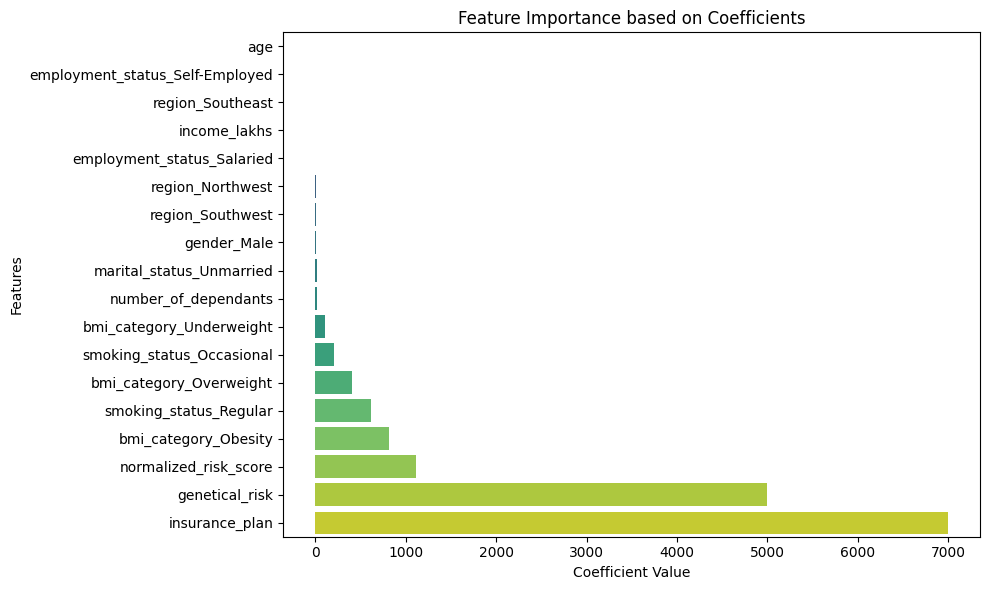

In [7]:
# create barh chart for coef_df
plt.figure(figsize=(10, 6))
sns.barplot(x="Coefficient", y=coef_df.index, data=coef_df, palette="viridis")
plt.title("Feature Importance based on Coefficients")
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [8]:
# use XGboost for better performance (optional)
from xgboost import XGBRegressor

# train XGBoost model
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

# test the model both train and test
xgb_train_score = xgb_model.score(X_train, y_train)
xgb_test_score = xgb_model.score(X_test, y_test)

print(f"XGBoost Train Score: {xgb_train_score}")
print(f"XGBoost Test Score: {xgb_test_score}")

XGBoost Train Score: 0.9925054907798767
XGBoost Test Score: 0.987729549407959


In [9]:
best_model = lr_model

***Error Analysis**

In [10]:
y_pred = best_model.predict(X_test)

In [11]:
# residuals and pct.
residuals =  y_pred - y_test
residuals_pct = residuals  * 100 / y_test

results_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred,
    "diff": residuals,
    "diff_pct": residuals_pct
})

results_df.head()

,Actual,Predicted,diff,diff_pct
12765,6238,6121.456891,-116.543109,-1.868277
14749,9462,9601.797510,139.797510,1.477463
13196,5152,5611.056493,459.056493,8.910258
14269,6988,7423.486322,435.486322,6.231916
19341,4917,5112.056543,195.056543,3.966983


<Axes: xlabel='diff_pct', ylabel='Count'>

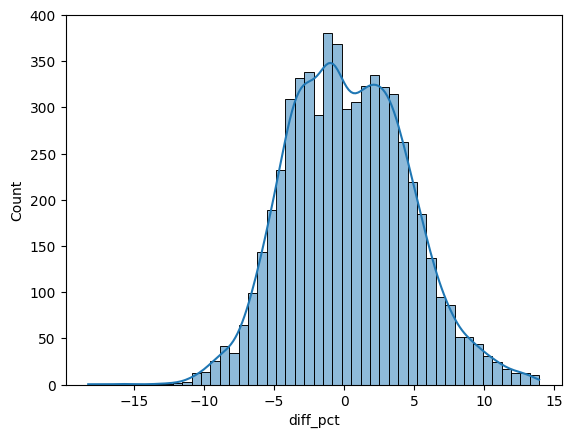

In [15]:
# plot histogram of diff_pct for resduals percentage
sns.histplot(results_df['diff_pct'],kde=True)

In [12]:
# find extreame errors threshold 10%
extreme_results_df = results_df[np.abs(results_df["diff_pct"]) > 10]
extreme_results_df.shape

(129, 4)

In [13]:
# pertange of error predictions
extreme_error_percentage = (extreme_results_df.shape[0] / results_df.shape[0]) * 100
extreme_error_percentage

2.140723531364089

In [16]:
X_test.index

Index([12765, 14749, 13196, 14269, 19341, 10613, 16381, 14790, 17174, 16338,
       ...
        8687,  9650, 14186,  1364,   398, 17642,  5803, 10289, 13307,  2581],
      dtype='int64', length=6026)

In [17]:
extreme_results_df.index

Index([12660,  2916, 17074,  7175, 12276, 13467, 15471,  2946,  4915, 15160,
       ...
       15156, 19570, 15654,  4202,  8684,  1984,  8000,  9706,  7351,  1533],
      dtype='int64', length=129)

In [18]:
extreme_error_df = X_test.loc[extreme_results_df.index]
extreme_error_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
12660,0.857143,0.000000,0.000000,0.0,0.0,0.0,1,0,1,0,1,0,1,0,0,0,1,0
2916,0.285714,0.000000,0.151515,0.0,0.2,0.0,1,1,0,0,1,0,0,0,0,0,1,0
17074,1.000000,0.000000,0.353535,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0
7175,0.571429,0.000000,0.161616,0.0,0.0,0.0,1,0,0,1,1,0,0,0,0,0,0,0
12276,0.428571,0.333333,0.232323,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0


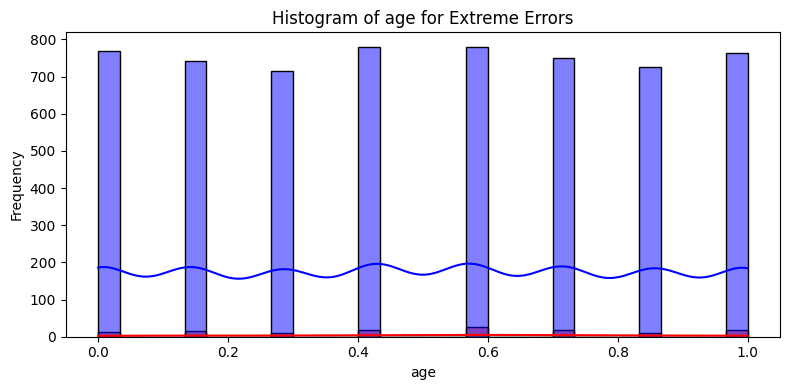

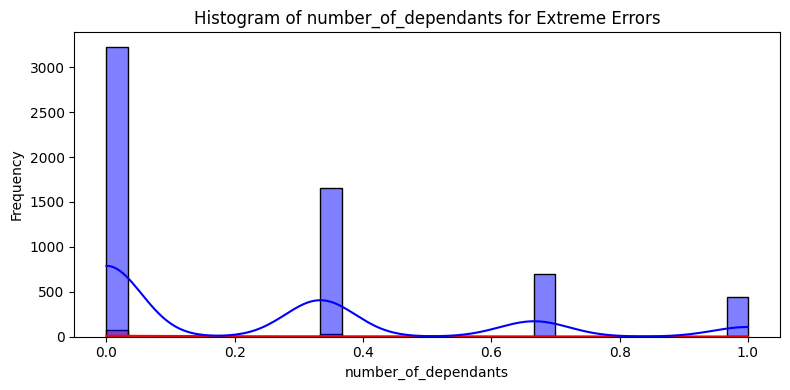

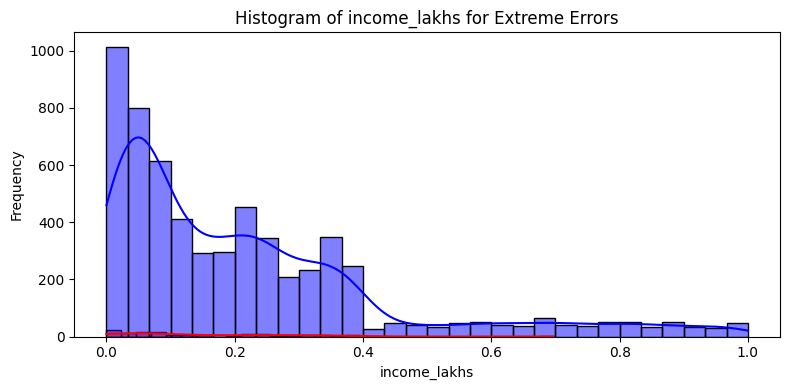

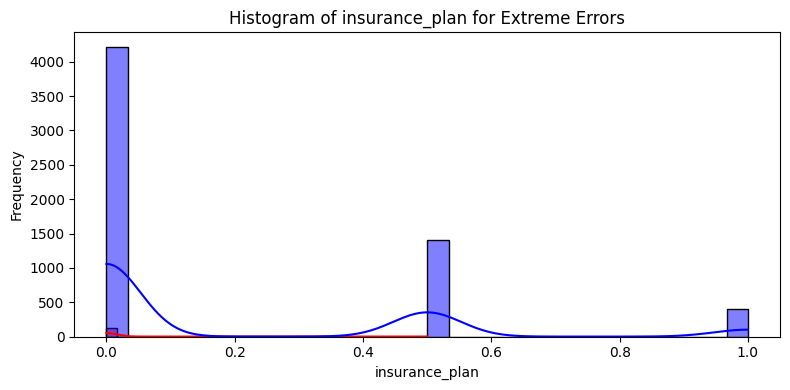

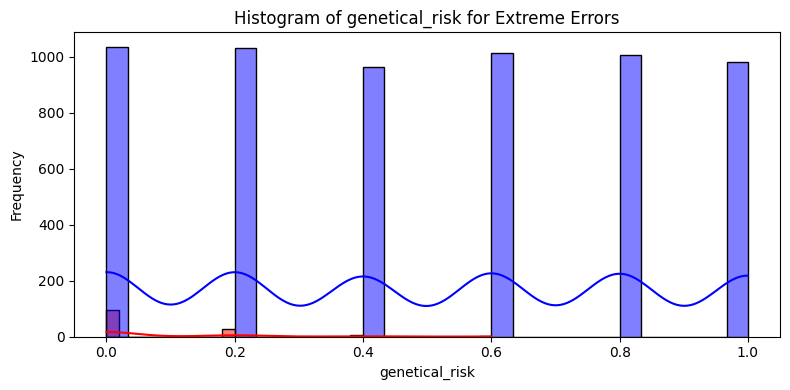

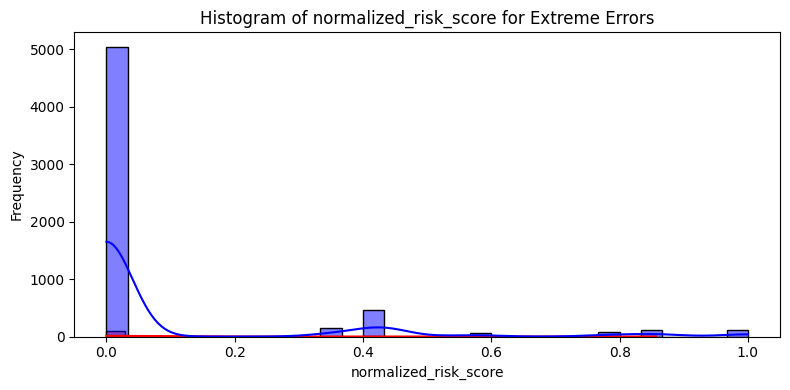

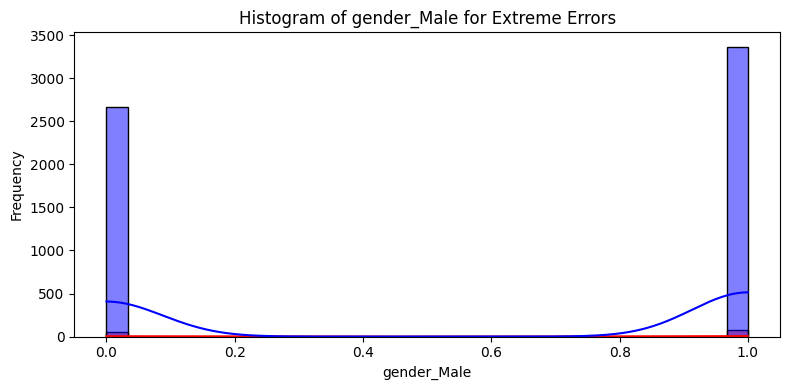

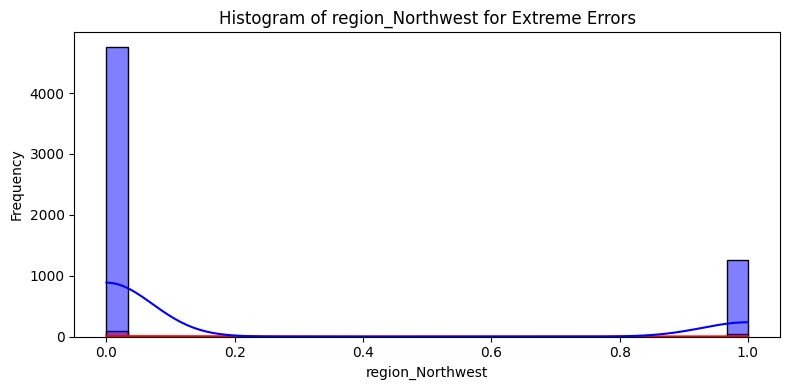

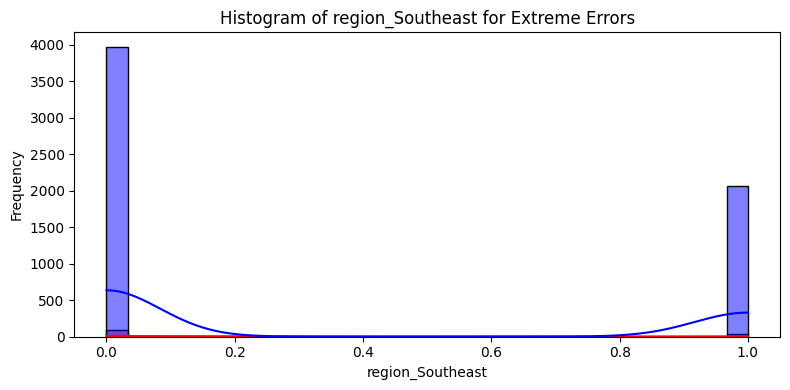

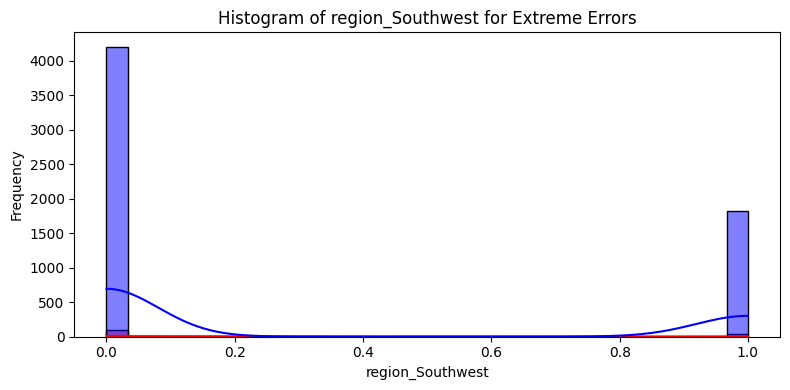

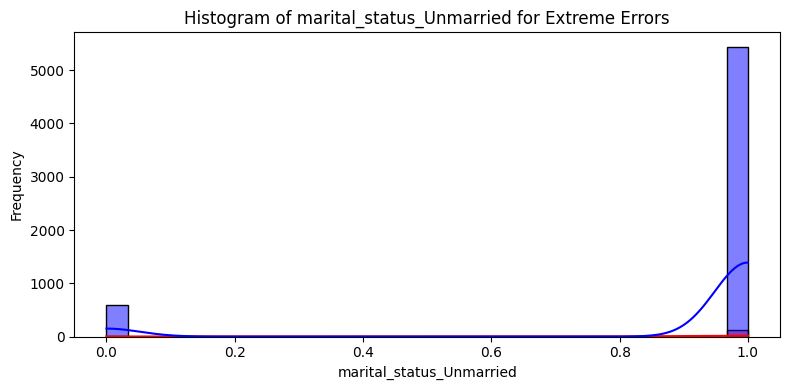

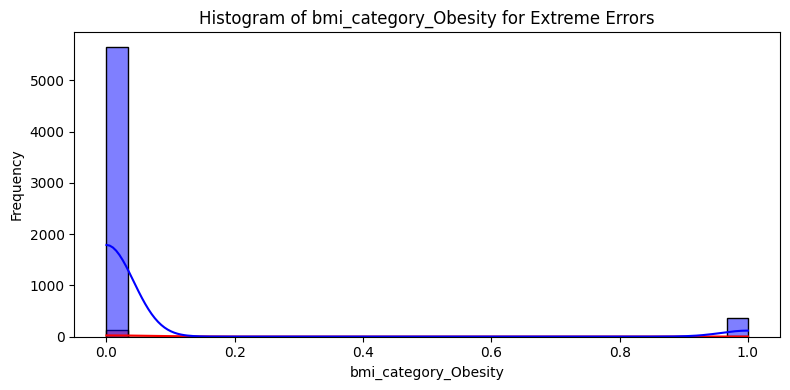

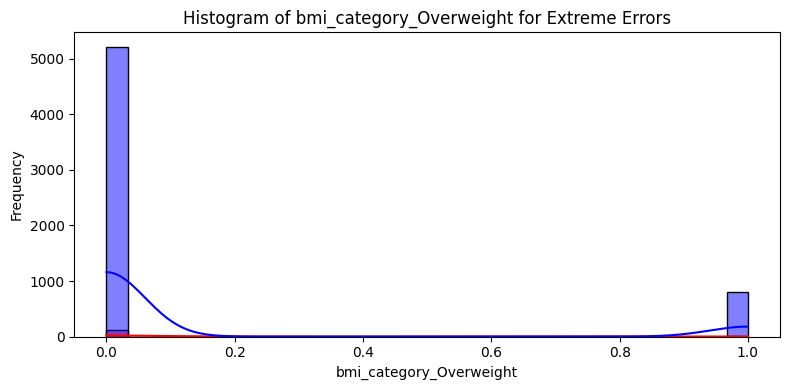

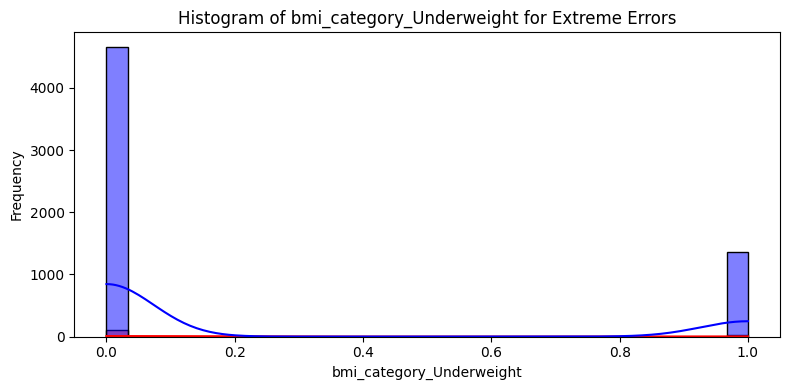

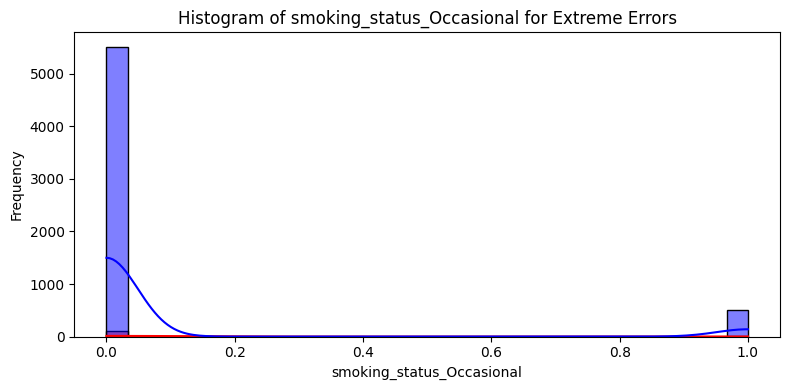

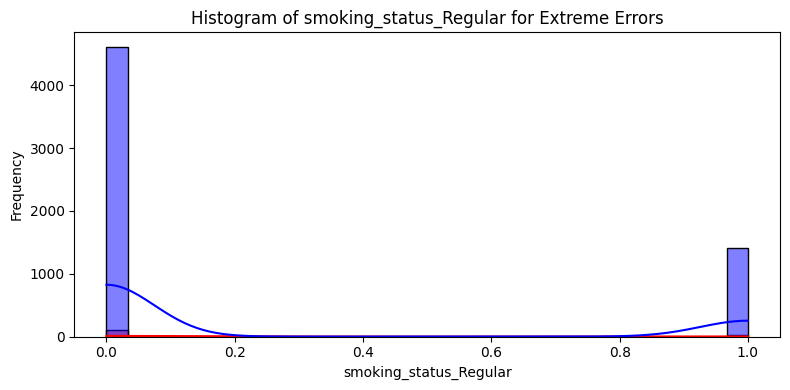

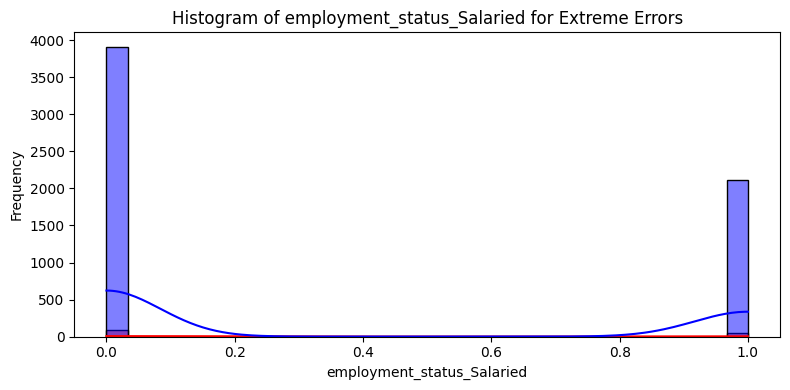

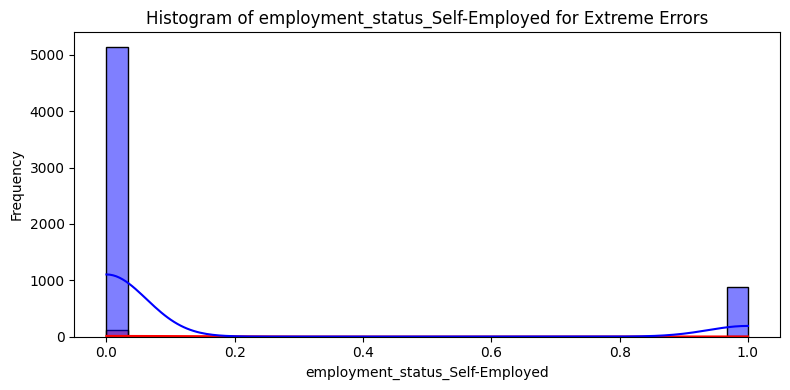

In [19]:
# print histogram of extreme error for features
for column in X_test.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(extreme_error_df[column], color='red', label = 'Extreme Errors', bins=30, kde=True)
    sns.histplot(X_test[column], color='blue', label = 'Overall', bins=30, kde=True, alpha=0.5)
    plt.title(f'Histogram of {column} for Extreme Errors')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

***Export the final model***

In [21]:
from joblib import dump
dump(best_model, '../artifacts/linear_regression_young_gr_model.joblib')

['../artifacts/linear_regression_young_gr_model.joblib']